In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
import lightgbm as lgb

# 读取数据
train_df = pd.read_csv('../data/糖尿病遗传风险预测挑战赛公开数据/比赛训练集.csv', encoding='gbk')
test_df = pd.read_csv('../data/糖尿病遗传风险预测挑战赛公开数据/比赛测试集.csv', encoding='gbk')


# 基础特征工程
train_df['体重指数_round'] = train_df['体重指数'] // 10
test_df['体重指数_round'] = test_df['体重指数'] // 10

train_df['舒张压指数_round'] = train_df['舒张压'] // 90 + 1
test_df['舒张压数_round'] = test_df['舒张压'] // 90 + 1



train_df['口服耐糖量测试'] = train_df['口服耐糖量测试'].replace(-1, np.nan)
test_df['口服耐糖量测试'] = test_df['口服耐糖量测试'].replace(-1, np.nan)

dict_糖尿病家族史 = {
    '无记录': 0,
    '叔叔或姑姑有一方患有糖尿病': 1,
    '叔叔或者姑姑有一方患有糖尿病': 1,
    '父母有一方患有糖尿病': 2
}

train_df['糖尿病家族史'] = train_df['糖尿病家族史'].map(dict_糖尿病家族史)
test_df['糖尿病家族史'] = test_df['糖尿病家族史'].map(dict_糖尿病家族史)

train_df['糖尿病家族史'] = train_df['糖尿病家族史'].astype('category')
test_df['糖尿病家族史'] = test_df['糖尿病家族史'].astype('category')

train_df['性别'] = train_df['性别'].astype('category')
test_df['性别'] = test_df['性别'].astype('category')

train_df['年龄'] = 2022 - train_df['出生年份']
test_df['年龄'] = 2022 - test_df['出生年份']

train_df['年龄_round'] = train_df['年龄'] // 30 
test_df['年龄_round'] = test_df['年龄'] // 30 

train_df['口服耐糖量测试_diff'] = train_df['口服耐糖量测试'] - train_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
test_df['口服耐糖量测试_diff'] = test_df['口服耐糖量测试'] - test_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
# 模型交叉验证
def run_model_cv(model, kf, X_tr, y, X_te, cate_col=None):
    train_pred = np.zeros( (len(X_tr), len(np.unique(y))) )
    test_pred = np.zeros( (len(X_te), len(np.unique(y))) )

    cv_clf = []
    for tr_idx, val_idx in kf.split(X_tr, y):
        x_tr = X_tr.iloc[tr_idx]; y_tr = y.iloc[tr_idx]

        x_val = X_tr.iloc[val_idx]; y_val = y.iloc[val_idx]

        call_back = [
            lgb.early_stopping(50),
        ]
        eval_set = [(x_val, y_val)]
        model.fit(x_tr, y_tr, eval_set=eval_set, callbacks=call_back, verbose=-1)

        cv_clf.append(model)

        train_pred[val_idx] = model.predict_proba(x_val)
        test_pred += model.predict_proba(X_te)

    test_pred /= kf.n_splits
    return train_pred, test_pred, cv_clf

clf = lgb.LGBMClassifier(
    max_depth=5, 
    n_estimators=8000, 
    n_jobs=-1, 
    verbose=-1,
    verbosity=-1,
    learning_rate=0.05,
)

train_pred, test_pred, cv_clf = run_model_cv(
    clf, KFold(n_splits=5),
    train_df.drop(['编号', '患有糖尿病标识'], axis=1),
    train_df['患有糖尿病标识'],
    test_df.drop(['编号'], axis=1),
)

print((train_pred.argmax(1) == train_df['患有糖尿病标识']).mean())


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12224\1194460207.py:46: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  train_df['口服耐糖量测试_diff'] = train_df['口服耐糖量测试'] - train_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12224\1194460207.py:47: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  test_df['口服耐糖量测试_diff'] = test_df['口服耐糖量测试'] - test_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'cal

[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.128569
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds


D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.115333
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds


D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.111592
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds


D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.1341
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds


D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.0965836
0.9591715976331361


FileNotFoundError: [Errno 2] No such file or directory: '../images/train_pearson.jpg'

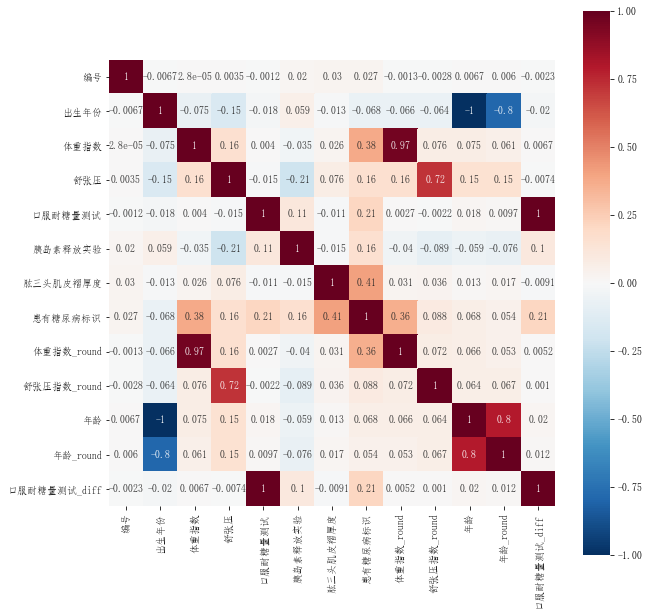

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['FangSong']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.subplots(figsize=(10,10))
sns.heatmap(train_df.corr(method='pearson'), annot=True, vmax=1, square=True, cmap='RdBu_r')
plt.savefig('../images/train_pearson.jpg', dpi=800)

In [76]:
train_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12224\2269712116.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  train_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']


0       5.896475
1       5.896475
2       5.896475
3       5.896475
4       5.967212
          ...   
5065    6.125952
5066    5.967212
5067    5.896475
5068    6.125952
5069    5.896475
Name: 口服耐糖量测试, Length: 5070, dtype: float64